In [ ]:
import os
import h2o
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.automl import H2OAutoML
from h2o.estimators import H2ODeepLearningEstimator

# Descarga de dataset Kaggle

In [35]:
path = kagglehub.dataset_download("dev7halo/wine-information", force_download=False)
print("Dataset downloaded to:", path)
os.listdir(path)

Dataset downloaded to: /home/giorgio6846/.cache/kagglehub/datasets/dev7halo/wine-information/versions/7


['cleansingWine.csv', 'wine_info.csv']

# Inicializacion de h2o

In [36]:
h2o.init(ip="172.25.197.59", port=54323)

Checking whether there is an H2O instance running at http://172.25.197.59:54323. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,4 hours 0 mins
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 15 days
H2O_cluster_name:,MyH2OCluster
H2O_cluster_total_nodes:,2
H2O_cluster_free_memory:,31.21 Gb
H2O_cluster_total_cores:,28
H2O_cluster_allowed_cores:,28
H2O_cluster_status:,"locked, healthy"


In [37]:
kaggle_dir = "data"
kaggle_path = os.path.join(kaggle_dir, "cleansingWine.csv")
print("Cargando datos:", kaggle_path)

smb_dir = (
    "/mnt/sambashare/BigData-DATA"
)
smb_path = os.path.join(smb_dir, "cleansingWine.csv")
print(smb_path, os.listdir(smb_dir))

Cargando datos: data/cleansingWine.csv
/mnt/sambashare/BigData-DATA/cleansingWine.csv ['test', 'cleansingWine.csv']


# Carga de datos

In [38]:
df = h2o.import_file(smb_path)
print(df.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(21605, 32)


## Remover features

In [39]:
# Remove column C1

df = df.drop("C1")
df = df.drop(["price", "year", "ml", "id", "name"])

df.describe()

Rows:21605
Cols:26

,producer,nation,local1,local2,local3,local4,varieties1,varieties2,varieties3,varieties4,varieties5,varieties6,varieties7,varieties8,varieties9,varieties10,varieties11,varieties12,type,use,abv,degree,sweet,acidity,body,tannin
type,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,string,string,string,string,enum,enum,real,enum,enum,enum,enum,enum
mins,,,,,,,,,,,,,,,NaN,NaN,NaN,NaN,,,0.0,,,,,
mean,,,,,,,,,,,,,,,0.0,0.0,0.0,0.0,,,13.269316517493897,,,,,
maxs,,,,,,,,,,,,,,,NaN,NaN,NaN,NaN,,,70.0,,,,,
sigma,,,,,,,,,,,,,,,-0.0,-0.0,-0.0,-0.0,,,3.0673539938435073,,,,,
zeros,,,,,,,,,,,,,,,0,0,0,0,,,1,,,,,
missing,0,2,900,10460,18014,21603,349,14087,17577,20275,21226,21500,21574,21587,21598,21599,21600,21601,58,14,11773,7145,2,13,13,13
0,Altair,Chile,Rapel Valley,,,,Cabernet Sauvignon,Carmenere,Merlot,,,,,,,,,,Red,Table,nan,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4
1,Altair,Chile,Rapel Valley,,,,Cabernet Sauvignon,Merlot,Carmenere,Cabernet Franc,Syrah & Shiraz,Petit Verdot,,,,,,,Red,Table,nan,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4
2,Baron du Val,France,,,,,Carignan,Cinsault,Syrah & Shiraz,Grenache Noir,,,,,,,,,Red,Table,nan,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2


# EDA

In [40]:
#plt.pie(df["nation"])
nations = df.group_by("nation").count()
nationsDF = nations.get_frame()


Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


<Axes: ylabel='nrow'>

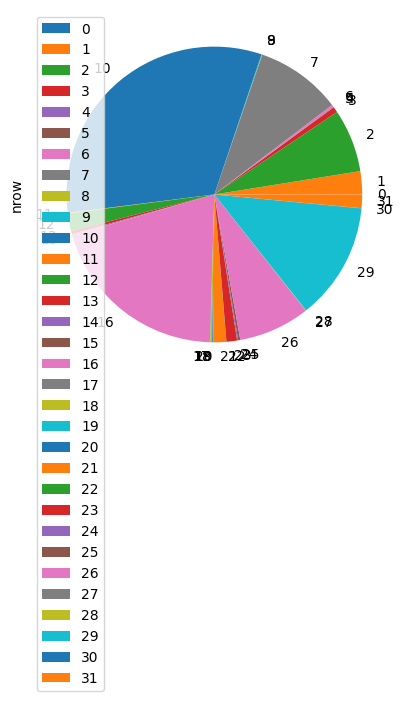

In [41]:
nationsDF.as_data_frame(use_multi_thread=True).plot.pie(
    x="nation",y="nrow",
)

# Training

In [42]:
train, valid = df.split_frame(ratios=[0.8], seed=1234)

In [43]:
predictors = df.columns
print(predictors)
for col in ["sweet", "acidity", "body", "tannin"]:
    predictors.remove(str(col))

['producer', 'nation', 'local1', 'local2', 'local3', 'local4', 'varieties1', 'varieties2', 'varieties3', 'varieties4', 'varieties5', 'varieties6', 'varieties7', 'varieties8', 'varieties9', 'varieties10', 'varieties11', 'varieties12', 'type', 'use', 'abv', 'degree', 'sweet', 'acidity', 'body', 'tannin']


In [45]:
models1 = {}
for target in ["sweet","acidity","body","tannin"]:
    aml = H2OAutoML(max_models=20, seed=1)
    aml.train(x=predictors, y=target, training_frame=train)
    models1[target] = aml.leader

AutoML progress: |
18:21:26.550: _train param, Dropping bad and constant columns: [varieties9, varieties10, varieties12, varieties11]


18:21:27.306: XGBoost_1_AutoML_1_20250712_182126 [XGBoost def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_1_AutoML_1_20250712_182126_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.

18:21:27.329: _train param, Dropping bad and constant columns: [varieties9, varieties10, varieties12, local4, varieties11]

████████████████████████████████████████████████ (cancelled)


H2OJobCancelled: Job<$0301ac19c53b34d4ffffffff$_a0a402fe8d177499675165c7b3c94c13> was cancelled by the user.

In [ ]:
dl = H2ODeepLearningEstimator(
    distribution="gaussian",
    hidden=[50,50],
    epochs=20
)
dl.train(x=predictors, y=["sweet","acidity","body","tannin"], training_frame=train)
models2 = {"multi": dl}